### First step:
The first step is undoubtedly to read the data in xslx format and convert them to csv in order to be able to analyse them via pandas. In this first cell, certain functions are also defined which will be useful later on:
- <code>force_to_numeric</code>: this function has the task of converting all instances of values in the selected columns into numeric values, this function was developed to deal with the problem resulting from the fact that in some datasets the datatype of individual instances is sometimes not numeric (probably due to NaN values).
- <code>knn_impute</code>: this function has a dual purpose, that of calculating the ideal number of neighbours and then using this number as the value for imputing missing data into the dataframes resulting from the merge. This algorithm proposes missing values by calculating them according to a learning model that produces 'plausible' data. Its logic follow these steps:
- - Numeric Data Selection: Select numeric columns from the input DataFrame (dataframe).
- - Cross-Validation for k Selection: Iterate over a range of values for the number of neighbors (k) from 1 to 50. Use k-NN imputation with each k and calculate cross-validated mean squared error scores. Keep track of the scores for each k.
- - Optimal k Selection: Identify the optimal k that minimizes the mean squared error.
- - Final Imputation: Use the optimal k to perform k-NN imputation on the entire numeric dataset. Replace missing values in the original DataFrame with the imputed values. 
- - Return Results: Return the updated DataFrame and the optimal k.
- <code>column_remove</code>: This function was developed with the sole purpose of limiting and thus equalising all datasets by only examining columns referring to data from 2018 onwards.
- <code>generate_overall_trend_correlation</code>: This function aims to calculate the overall correlation of a dataset based on the difference of individual values taken and compared year by year.
- <code>generate_yearly_correlations</code>: This function has a similar purpose to the one just discussed, it generates correlations between the absolute values of each instance taken individually year by year.

In [303]:
import openpyxl
import csv 
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")
#pulzia dati e creazione file csv

def force_to_numeric(dataframe1, dataframe2, dataframe3):
    cols = ['2023', '2022', '2021', '2020', '2019', '2018']
    for col in cols:
        try:
            dataframe1[col] = pd.to_numeric(dataframe1[col], errors='coerce')
        except KeyError:
            pass  
        try:
            dataframe2[col] = pd.to_numeric(dataframe2[col], errors='coerce')
        except KeyError:
            pass
        try:
            dataframe3[col] = pd.to_numeric(dataframe3[col], errors='coerce')
        except KeyError:
            pass
    return dataframe1, dataframe2, dataframe3


def knn_impute(dataframe):
    numeric_data = dataframe.select_dtypes(include=[np.number])
    cv_scores = []
    for k in range(1, 51):
        imputer = KNNImputer(n_neighbors=k)
        scores = cross_val_score(imputer, numeric_data, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(scores.mean())
    optimal_k = cv_scores.index(max(cv_scores)) + 1
    print(f"Optimal number of neighbors (k): {optimal_k}")
    imputer = KNNImputer(n_neighbors=optimal_k)
    imputed_data = imputer.fit_transform(numeric_data)
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns)
    dataframe[numeric_data.columns] = imputed_df
    return dataframe, optimal_k

def iterative_impute(dataframe, tol=1e-3, max_iter=10):
    numeric_data = dataframe.select_dtypes(include=[np.number])
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1), random_state=42)
    diff = tol
    iter_count = 0
    while diff >= tol and iter_count < max_iter:
        prev_imputed = imputer.fit_transform(numeric_data)
        imputer = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1), random_state=42)
        curr_imputed = imputer.fit_transform(numeric_data)
        diff = np.linalg.norm(prev_imputed - curr_imputed)
        iter_count += 1
    print(f"Optimal number of iterations: {iter_count}")
    imputed_df = pd.DataFrame(curr_imputed, columns=numeric_data.columns)
    dataframe[numeric_data.columns] = imputed_df
    return dataframe, iter_count


def mice_impute(dataframe, max_iter=50):
    numeric_data = dataframe.select_dtypes(include=[np.number])
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0, n_jobs=-1), max_iter=max_iter, random_state=42)
    imputed_data = imputer.fit_transform(numeric_data)
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns)
    dataframe[numeric_data.columns] = imputed_df
    return dataframe

def column_remove(dataframe1, dataframe2, dataframe3):
    dataframe1 = dataframe1.iloc[:, :7]
    dataframe2 = dataframe2.iloc[:, :7]
    dataframe3 = dataframe3.iloc[:, :7]
    return dataframe1, dataframe2, dataframe3

def generate_overall_trend_correlation(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame) -> None:
    """
    Calculates the correlation between the differences in values for each column of three input dataframes and prints the results.

    Args:
        df1 (pd.DataFrame): The first input dataframe.
        df2 (pd.DataFrame): The second input dataframe.
        df3 (pd.DataFrame): The third input dataframe.

    Returns:
        None: The function only prints the correlation matrices for each column.
    """
    common_columns = df1.columns.intersection(df2.columns).intersection(df3.columns)

    for column in common_columns:
        diff_df1 = df1[column].diff().dropna()
        diff_df2 = df2[column].diff().dropna()
        diff_df3 = df3[column].diff().dropna()
        merged_diff_df = pd.concat([diff_df1, diff_df2, diff_df3], axis=1)
        correlation = merged_diff_df.corr(method="spearman")
        print(f'Correlation in trend for {column}:\n', correlation)
        
def generate_yearly_correlations(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame) -> None:
    """
    Calculates the correlation between columns of three input dataframes and prints the results.

    Args:
        df1 (pd.DataFrame): The first input dataframe.
        df2 (pd.DataFrame): The second input dataframe.
        df3 (pd.DataFrame): The third input dataframe.

    Returns:
        None: The function only prints the correlation matrices for each common column.
    """
    common_columns = df1.columns.intersection(df2.columns).intersection(df3.columns)
    
    for column in common_columns:
        merged_df = pd.concat([df1[column], df2[column], df3[column]], axis=1)
        correlation = merged_df.corr(method="spearman")
        print(f'Correlation for {column}:\n', correlation)


#education science and research
df_total_research_fundings = pd.read_excel("../data/education_science_research/total_research_funding.xlsx", skiprows=18)
df_men_research_fundings = pd.read_excel("../data/education_science_research/men_research_funding.xlsx", skiprows=18)
df_women_research_fundings = pd.read_excel("../data/education_science_research/women_research_funding.xlsx", skiprows=18)
df_total_research_fundings.to_csv("../data/education_science_research/total_research_funding.csv", index=False)
df_men_research_fundings.to_csv("../data/education_science_research/men_research_funding.csv", index=False)
df_women_research_fundings.to_csv("../data/education_science_research/women_research_funding.csv", index=False)


#environment and climate change
df_total_political_executives = pd.read_excel("../data/environment_climate_change/total_political_executives_climate.xlsx", skiprows=18)
df_men_political_executives = pd.read_excel("../data/environment_climate_change/men_political_executives_climate.xlsx", skiprows=18)
df_women_political_executives = pd.read_excel("../data/environment_climate_change/women_political_executives_climate.xlsx", skiprows=18)
df_total_political_executives.to_csv("../data/environment_climate_change/total_political_executives_climate.csv", index=False)
df_men_political_executives.to_csv("../data/environment_climate_change/men_political_executives_climate.csv", index=False)
df_women_political_executives.to_csv("../data/environment_climate_change/women_political_executives_climate.csv", index=False)


#major political party leaders
df_total_political_parties = pd.read_excel("../data/major_political_party_leaders/total_political_parties.xlsx", skiprows=18)
df_men_political_parties = pd.read_excel("../data/major_political_party_leaders/men_political_parties.xlsx", skiprows=18)
df_women_political_parties = pd.read_excel("../data/major_political_party_leaders/women_political_parties.xlsx", skiprows=18)
df_total_political_parties.to_csv("../data/major_political_party_leaders/total_political_parties.csv", index=False)
df_men_political_parties.to_csv("../data/major_political_party_leaders/men_political_parties.csv", index=False)
df_women_political_parties.to_csv("../data/major_political_party_leaders/women_political_parties.csv", index=False)



#public EU administrations
df_public_adm_total = pd.read_excel("../data/European_public_admin/european_agencies_total.xlsx", skiprows=18)
df_public_adm_men = pd.read_excel("../data/European_public_admin/european_agencies_men.xlsx", skiprows=18)
df_public_adm_women = pd.read_excel("../data/European_public_admin/european_agencies_women.xlsx", skiprows=18)
df_public_adm_total.to_csv("../data/European_public_admin/european_agencies_total.csv", index=False)
df_public_adm_men.to_csv("../data/European_public_admin/european_agencies_men.csv", index=False)
df_public_adm_women.to_csv("../data/European_public_admin/european_agencies_women.csv", index=False)


#european courts
df_total_european_court = pd.read_excel("../data/european_courts/total_judges_european_court.xlsx", skiprows=18)
df_men_european_court = pd.read_excel("../data/european_courts/men_judges_european_court.xlsx", skiprows=18)
df_women_european_court = pd.read_excel("../data/european_courts/women_judges_european_court.xlsx", skiprows=18)
df_total_european_court.to_csv("../data/european_courts/total_judges_european_court.csv", index=False)
df_men_european_court.to_csv("../data/european_courts/men_judges_european_court.csv", index=False)
df_women_european_court.to_csv("../data/european_courts/women_judges_european_court.csv", index=False)


#european finance
df_european_financial_institutions_total = pd.read_excel("../data/European_finance/european_financial_institutions_total.xlsx", skiprows=18)
df_european_financial_institutions_men = pd.read_excel("../data/European_finance/european_financial_institutions_men.xlsx", skiprows=18)
df_european_financial_institutions_women = pd.read_excel("../data/European_finance/european_financial_institutions_women.xlsx", skiprows=18)
df_european_financial_institutions_total.to_csv("../data/European_finance/european_financial_institutions_total.csv", index = False)
df_european_financial_institutions_men.to_csv("../data/European_finance/european_financial_institutions_men.csv", index= False)
df_european_financial_institutions_women.to_csv("../data/European_finance/european_financial_institutions_women.csv", index= False)

### First look at correlations of the dataframes

Using the two functions developed above we can start to look at the correlations: The first function looks at the correlation between the absolute values of the columns, while the second function looks at the correlation between the trends or changes in values over time for each column. The second function is useful when you are interested in understanding how the trends in values for common columns correlate between two dataframes.
Before doing that bowt <code>column_remove</code> and <code>force_to_numeric</code> functions have been applied in order to limitate our anlysis starting from 2018 to 2023 and to make every value numeric in the dataset. This second option is needed because no modification on the dataset have been applied so far. Later it will be possible to see how this situations has been managed

In [304]:
df_women_research_fundings, df_women_political_executives, df_women_political_parties = column_remove(df_women_research_fundings, df_women_political_executives, df_women_political_parties)
df_women_research_fundings, df_women_political_executives, df_women_political_parties = force_to_numeric(df_women_research_fundings, df_women_political_executives, df_women_political_parties)

generate_overall_trend_correlation(df_women_research_fundings.iloc[:, 1:], df_women_political_executives.iloc[:, 1:], df_women_political_parties.iloc[:, 1:])
generate_yearly_correlations(df_women_research_fundings.iloc[:, 1:], df_women_political_executives.iloc[:, 1:], df_women_political_parties.iloc[:, 1:])


Correlation in trend for 2022:
           2022      2022      2022
2022  1.000000  0.618603  0.411347
2022  0.618603  1.000000  0.234308
2022  0.411347  0.234308  1.000000
Correlation in trend for 2021:
           2021      2021      2021
2021  1.000000  0.538678  0.474340
2021  0.538678  1.000000  0.531956
2021  0.474340  0.531956  1.000000
Correlation in trend for 2020:
           2020      2020      2020
2020  1.000000  0.500131  0.472281
2020  0.500131  1.000000  0.544984
2020  0.472281  0.544984  1.000000
Correlation in trend for 2019:
           2019      2019      2019
2019  1.000000  0.440870  0.392057
2019  0.440870  1.000000  0.404364
2019  0.392057  0.404364  1.000000
Correlation in trend for 2018:
           2018      2018      2018
2018  1.000000  0.404348  0.310780
2018  0.404348  1.000000  0.505595
2018  0.310780  0.505595  1.000000
Correlation for 2022:
           2022      2022      2022
2022  1.000000  0.506425  0.396863
2022  0.506425  1.000000  0.350832
2022  0.3968

### Merging all dataset that share the Geographic region column

At this point in the work, in order to identify correlations and other broader types of analysis, it is necessary to merge datasets that share common columns such as the first case 'Geographic region'. The data in these are those concerning the influential roles women play in 
- Research funding organisations: presidents and members of the highest decision-making body
- Major political parties: leaders and deputy leaders 
- National ministries dealing with environment and climate change

Each of these datasets is categorised according to the region to which the women in question belong, with an additional row covering the entirety of the pre- and post-Brexit EU region.

Once the merge of the datasets is complete, the <code>knn_impute</code> function is applied to address missing values (NaN) in the dataset and so to plausibly replace by estimating them based on the values of the most similar observations.
The knn algorithm follow this logic of action: Given a dataset with features (independent variables) and a target variable (dependent variable), the k-NN algorithm compute the distance (commonly Euclidean distance) between the data point with missing values and all other data points in the dataset. At this point it identify the k nearest neighbors (data points with the smallest distances) to the data point with missing values. At the end it impute missing values with the average (or weighted average) of the target values of its k nearest neighbors.

In other words the goal is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. 
For a data point with a missing value in a numeric feature $X_i$ and $k$ nearest neighbors with observed values
$X_{i_1}, X_{i_2}, ..., X_{i_k}$, the imputation formula is often the mean:

$$\text{Imputed Value} = \frac{1}{k} \sum_{j=1}^{k} X_{i_j} \$$


When it comes to KNN imputation, the algorithm works by imputing missing values in a dataset with the mean (for numerical data) or mode (for categorical data) of the ‘k’ nearest neighbors, as determined by some distance metric. The ‘k’ is dynamically calculated by the <code>knn_impute</code> function that estimates the optimum number of neighbors to adopt as parameter that dictates how many of the nearest neighbors contribute to the imputation.

It is worth to mention that the <code>KNNImputer</code> class in <code>scikit-learn</code> handles the complexities of the k-NN imputation algorithm, including distance metrics, weights, and handling missing values in the input data. The optimal $k$ is selected based on cross-validated mean squared error scores


In [305]:
#pol parties
#environments
#research

df_women_research_fundings = df_women_research_fundings.rename(columns={"Geographic region\Time": "Geographic region"})
df_women_political_executives = df_women_political_executives.rename(columns={"Geographic region\Time": "Geographic region"})
df_women_political_parties = df_women_political_parties.rename(columns={"Geographic region\Time": "Geographic region"})

merged_df = pd.merge(df_women_political_parties, df_women_research_fundings, on="Geographic region")
merged_df_final = pd.merge(merged_df, df_women_political_executives, on="Geographic region") 

# knn_impute(merged_df_final)
# iterative_impute(merged_df_final)
mice_impute(merged_df_final)
merged_df_final.head()


,Geographic region,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
0,Albania,0.0,0.0,1.0,1.0,1.0,1.0,5.0,5.0,4.0,4.0,4.0,4.0,6.0,1.0,2.0,3.0,2.0,1.5
1,Austria,2.0,2.0,2.0,2.0,2.0,0.0,18.0,19.0,18.0,13.0,12.0,12.0,1.0,2.0,1.0,1.0,1.0,0.0
2,Bosnia and Herzegovina,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0,0.3
3,Belgium,2.0,2.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,6.0,6.0,7.0,3.0,3.0,1.0,1.0,1.0,1.0
4,Bulgaria,1.0,1.0,1.0,1.0,1.0,1.0,6.0,6.0,5.0,5.0,4.0,4.0,3.0,4.0,3.0,3.0,2.0,2.0


### Spearman's correlation between variables in the merged dataset

At this point, to investigate and in case identify interesting correlation trends, it was decided to apply Spearman's correlation, which is particularly useful when dealing with non-linear data.

Spearman's rank correlation coefficient, denoted by ρ (rho), is a non-parametric measure of statistical dependence between two variables. It assesses how well the relationship between two variables can be described using a monotonic function. Unlike Pearson's correlation, Spearman's correlation does not assume a linear relationship between the variables.

The process involves ranking data points for each variable, ordering them from lowest to highest. In case of ties, the ranks are averaged. Subsequently, the differences (d) between the ranks of corresponding pairs of data points are computed. These differences are then squared (d²), and the sum of the squared differences is utilized to calculate Spearman's rank correlation coefficient.

Mathematical Formula:
$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$
 
where $\rho $ is the number of data points, and $ d_i $ represents the differences in ranks.


The advantage for Non-linear Data relies on Spearman's correlation capacity of being robust to outliers and the fact that it does not assume linearity. It is particularly useful when dealing with non-linear relationships, as it captures monotonic (increasing or decreasing) relationships. This makes it more suitable for assessing associations in datasets where the relationship between variables is not strictly linear.

Non-linear data generally refers to a situation where the relationship between two variables cannot be adequately represented by a straight line. In non-linear data, the pattern between variables may follow a curve, such as an exponential, logarithmic, or quadratic function. Spearman's correlation is advantageous in such cases, as it evaluates the strength and direction of monotonic relationships without relying on linear assumptions.

The demonstration of the non linearity of data is quite simple, it is necessary to plot two chosen variables from the dataframe and look at the general going of the dispositions of each point.

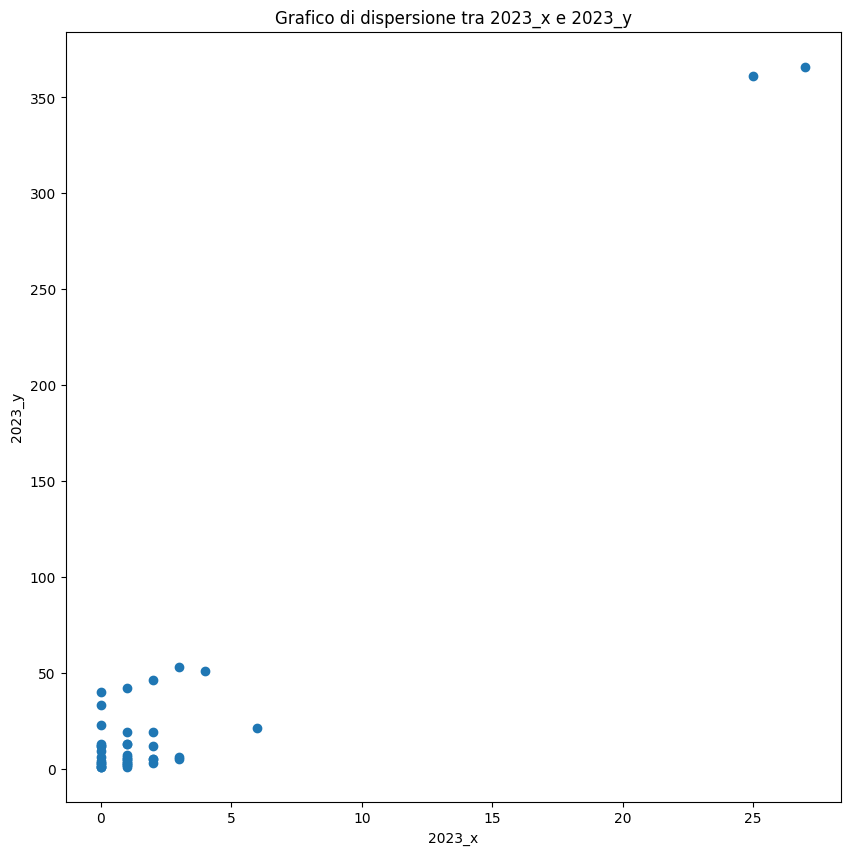

In [306]:
import matplotlib.pyplot as plt

# Creazione del grafico di dispersione
plt.figure(figsize=(10, 10))
plt.scatter(merged_df_final['2019_x'], merged_df_final['2022_y'])

# Aggiunta dei titoli agli assi e al grafico
plt.title('Grafico di dispersione tra 2023_x e 2023_y')
plt.xlabel('2023_x')
plt.ylabel('2023_y')

# Visualizzazione del grafico
plt.show()


In [307]:
spearman_corr = merged_df_final.corr(method='spearman')
spearman_corr

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
2023_x,1.000000,0.954163,0.896823,0.870298,0.693090,0.645940,0.374805,0.435110,0.398453,0.404340,0.388177,0.393640,0.340778,0.414706,0.452449,0.409532,0.363895,0.402961
2022_x,0.954163,1.000000,0.876656,0.867667,0.713015,0.637088,0.344821,0.396863,0.384073,0.381874,0.358363,0.370709,0.350832,0.413849,0.461233,0.440512,0.404881,0.438728
2021_x,0.896823,0.876656,1.000000,0.949752,0.794230,0.682060,0.332182,0.398803,0.366289,0.367553,0.346971,0.343503,0.438973,0.459797,0.561961,0.564980,0.493357,0.497743
2020_x,0.870298,0.867667,0.949752,1.000000,0.897829,0.771646,0.348001,0.417555,0.399838,0.406135,0.387995,0.389077,0.451420,0.498432,0.594794,0.583894,0.529976,0.569166
2019_x,0.693090,0.713015,0.794230,0.897829,1.000000,0.841107,0.319698,0.373247,0.379114,0.356727,0.363855,0.345930,0.339161,0.444691,0.514041,0.492792,0.508522,0.545481
2018_x,0.645940,0.637088,0.682060,0.771646,0.841107,1.000000,0.342385,0.387831,0.384262,0.400150,0.381615,0.371559,0.428724,0.495044,0.565646,0.516925,0.538421,0.631539
2023_y,0.374805,0.344821,0.332182,0.348001,0.319698,0.342385,1.000000,0.979035,0.963170,0.931363,0.926211,0.933285,0.498863,0.424111,0.406089,0.307233,0.293033,0.386084
2022_y,0.435110,0.396863,0.398803,0.417555,0.373247,0.387831,0.979035,1.000000,0.985786,0.969630,0.961388,0.964621,0.506425,0.467312,0.466857,0.357033,0.338873,0.439216
2021_y,0.398453,0.384073,0.366289,0.399838,0.379114,0.384262,0.963170,0.985786,1.000000,0.981296,0.972068,0.974493,0.482819,0.472426,0.465531,0.352503,0.346932,0.452050
2020_y,0.404340,0.381874,0.367553,0.406135,0.356727,0.400150,0.931363,0.969630,0.981296,1.000000,0.987163,0.986867,0.523659,0.504371,0.506110,0.383337,0.371276,0.469498



The numerical analysis of the Spearman correlation matrix provides further details on the strength of correlations and potential influences between categories. Based on the numerical values:

- Temporal Correlations within the Same Categories: Correlations within the same categories over the years are generally high (close to 1), suggesting a strong positive correlation. This indicates that gender dynamics in one category positively influence dynamics in similar categories in subsequent years.

- Correlations between Different Categories in the Same Year: Correlations between different categories in the same year vary, but often are significant. A high value indicates a positive relationship, while a low or negative value indicates a weaker or even negative relationship.

- Correlations Between Different Categories Over the Years: Correlations between different categories over time show significant variations. Some years exhibit stronger correlations than others, suggesting that gender dynamics in an agency in one year may influence other categories differently in subsequent years.

- Negative Values in Year-to-Year Correlations: Negative values indicate an inverse relationship between categories in those specific years. This suggests that in certain periods, an increase in the number of women in one category is associated with a decrease in other categories and vice versa.

- Correlations between Agencies in the Same Year: Correlations between different agencies in the same year indicate how gender dynamics in one agency may be linked to those in other agencies during the same period.

In summary, the numerical data confirm that similar categories exhibit a strong temporal correlation, while different categories may show varying degrees of correlation depending on the years. Negative values suggest complex dynamics, indicating that changes in the number of women in influential roles in certain categories may counterbalance variations in other categories. Further analyses and investigations could provide a deeper understanding of gender dynamics in European institutions over time.

### Heatmap of spearman's correlation for non linear variables

Correlation within the Same Domains Across Years: Cells with warmer colors (such as red) along the diagonal indicate a strong positive correlation within the same domain in consecutive years. This suggests that if the number of women in a specific domain increases or decreases in one year, a similar trend is likely to follow in the subsequent years.

Correlation between Different Domains in the Same Year: Cells not on the diagonal represent the correlation between different domains in the same year. For example, the cell intersecting 2023_x and 2023_y indicates the correlation between these two domains in 2023. If the color of this cell is warm, it means that if the number of women increases in one domain (2023_x), it is likely to increase in the other domain (2023_y) and vice versa.

Correlation between Different Domains Across Years: Cells neither on the diagonal nor in the same year show the correlation between different domains across years. For instance, the cell intersecting 2023_x and 2022_y indicates the correlation between domain x in 2023 and domain y in 2022. If the color of this cell is cool, it means that these two domains are not strongly correlated over time.

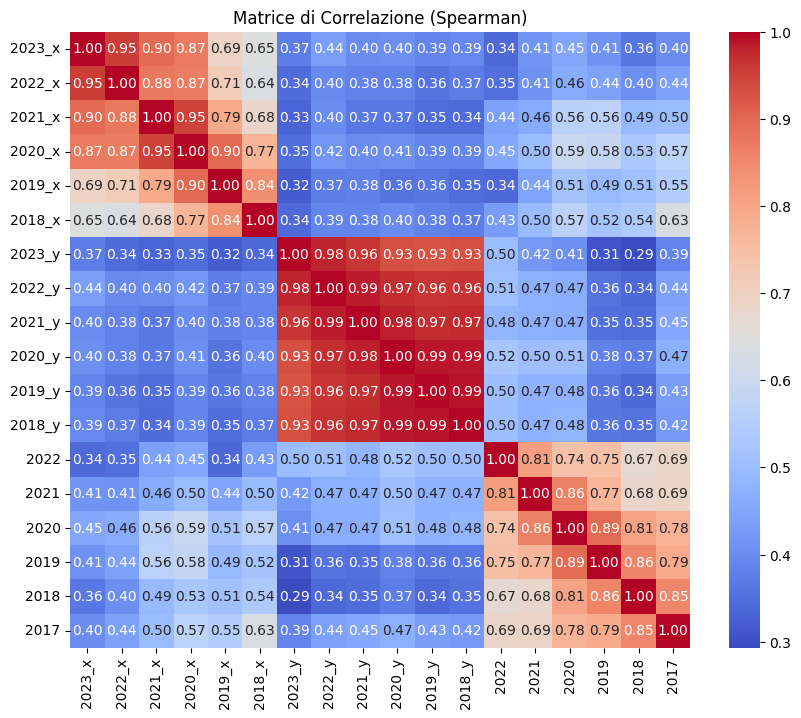

In [308]:
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione (Spearman)')
plt.show()

### Clusters and visualization

In this section, a different analysis approach was employed to identify any patterns in the dataset. Before proceeding with the cluster identification, it is necessary to employ the elbow method to determine the optimal number of clusters by which to partition the dataset.

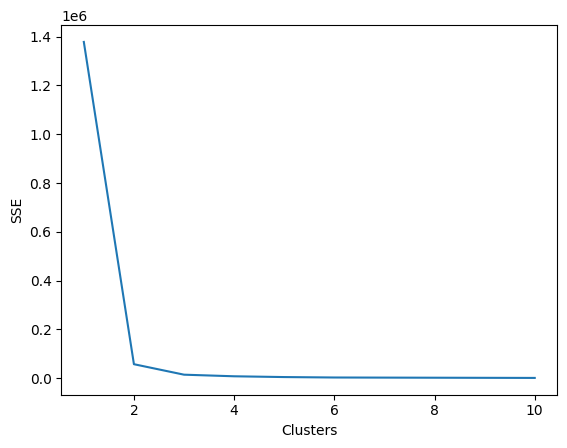

In [309]:
X = merged_df_final.iloc[:,1:].values

wcss = []
for i in range(1,11):
    k_means = cluster.KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_) 

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

The elbow method is a technique used to find the optimal number of clusters in a dataset for clustering algorithms, such as K-Means. It involves plotting the variance explained by the clusters against the number of clusters and observing the point at which adding more clusters does not significantly improve the variance explained. This point is visualized as an "elbow" in the plot, and the number of clusters corresponding to the elbow is considered the optimal choice. The elbow method helps strike a balance between achieving a good fit to the data and avoiding overfitting.

In [310]:

data = merged_df_final.select_dtypes(include=[np.number])
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
labels = kmeans.labels_
merged_df_final['Cluster'] = labels
labels
cluster_means = merged_df_final.groupby('Cluster').mean()
cluster_means


,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
Cluster,,,,,,,,,,,,,,,,,,
0,2.000000,1.666667,2.166667,2.000000,1.666667,1.500000,52.666667,42.500000,43.666667,43.000000,42.500000,41.166667,4.000000,2.333333,2.666667,2.333333,1.666667,2.166667
1,44.000000,40.500000,42.500000,34.500000,26.000000,28.000000,382.000000,363.500000,351.000000,339.000000,331.000000,321.000000,49.500000,48.500000,38.500000,39.000000,31.000000,30.500000
2,1.529412,1.382353,1.352941,1.147059,1.029412,1.058824,7.970588,7.617647,6.941176,6.441176,6.411765,6.352941,1.852941,1.823529,1.470588,1.382353,1.205882,1.023529


Although the elbow method plot strongly suggests adopting two clusters during the analysis, it was found to be a good choice to opt for three clusters instead. This decision was based, in part, on the averages of the values within each individual cluster, as seen above. The obtained means appear to fairly clearly indicate that there are three distinct patterns that differentiate the clusters.

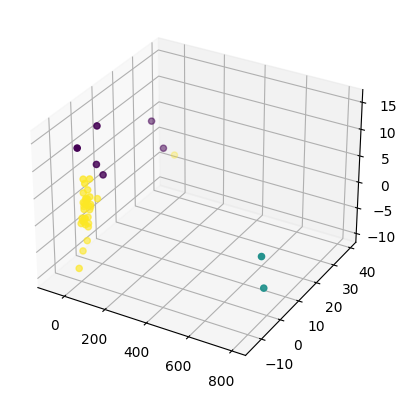

In [311]:
# Riduci la dimensionalità dei tuoi dati a 3 dimensioni utilizzando PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Crea una nuova figura
fig = plt.figure()

# Aggiungi un grafico 3D alla figura
ax = fig.add_subplot(111, projection='3d')

# Assegna a x, y, e z le tre componenti principali
x = reduced_data[:, 0]
y = reduced_data[:, 1]
z = reduced_data[:, 2]

# Crea un grafico a dispersione 3D utilizzando le etichette dei cluster per colorare i punti
scatter = ax.scatter(x, y, z, c=labels)

# Mostra il grafico
plt.show()


The 3D visualization provides a clear insight into how the choice of 3 clusters can be supported by the arrangement of points in the three-dimensional space based on the values they have taken. This visualization is obtained throguh the reduction of dimensionality of each point. The reduction of dimensionality, as performed by techniques like Principal Component Analysis (PCA), is often necessary for various reasons:

- Data Visualization: It is challenging to visualize high-dimensional data. Reducing the data to 2 or 3 dimensions can aid in visualizing and better understanding relationships between variables.

- Noise Reduction: Dimensionality reduction can help eliminate "noise" in the data, retaining only the most important features.

- Computational Efficiency: Machine learning models may be more efficient with fewer input variables. Reducing data dimensionality can speed up model training time and require fewer memory resources.

- Avoiding the Curse of Dimensionality: With a high number of dimensions, data becomes sparse, making it difficult for some machine learning algorithms to find meaningful patterns.

- Multicollinearity Reduction: In the presence of highly correlated variables, dimensionality reduction can help create new independent variables, potentially enhancing the performance of certain machine learning models.

To better understand what principal components represent in this case it is possible to say that principal components are new variables created as combinations of your original variables. These new variables are generated to capture the most data's information possible.

The original variables represent the number of women in influential roles for each year and category (2023_x, 2022_x, 2021_x, etc.). PCA creates new variables, known as principal components, which are combinations of these original variables. For example, the first principal component might be $0.3 \cdot 2023_x + 0.4 \cdot 2022_x - 0.2 \cdot 2021_x + \ldots$ This new variable is crafted to capture the majority of the variance (variation) in the data.
Each term in the expression represents a weight multiplied by the value of the corresponding original variable. The weights (0.3, 0.4, -0.2, etc.) are determined by the PCA algorithm during the analysis of the data. 

The positive or negative sign of each weight indicates the direction and strength of the relationship between the original variable and the principal component. In this case, a positive weight suggests a positive relationship, while a negative weight implies a negative relationship.
The magnitude of each weight signifies the importance or contribution of the respective original variable to the principal component. The purpose of creating this new variable (the first principal component) is to capture the majority of the variance or variation in the dataset.


By combining the original variables with specific weights, the principal component is constructed to highlight the patterns and variations present in the data. The principal components are typically ordered by the amount of variance they capture, with the first component capturing the most variance.
Using these principal components allows for a more concise representation of the data, reducing its dimensionality while retaining the essential information.


In summary, the formula for the first principal component is a linear combination of the original variables, designed to effectively summarize the patterns and variations in the data by assigning appropriate weights to each variable. In the 3D graph, each category is represented by a point, and the position of that point along the X-axis is determined by the value of the first principal component for that agency. Similarly, the position along the Y-axis is determined by the second principal component, and the position along the Z-axis is determined by the third principal component.

In [312]:
for cluster in merged_df_final['Cluster'].unique():
    cluster_data = merged_df_final[merged_df_final['Cluster'] == cluster]
    geo_region = cluster_data['Geographic region']
    
    # Stampa le agenzie
    print(f'Cluster {cluster}:')
    print(geo_region.head())


Cluster 2:
0                   Albania
1                   Austria
2    Bosnia and Herzegovina
3                   Belgium
4                  Bulgaria
Name: Geographic region, dtype: object
Cluster 0:
7                                               Germany
20    Instrument for Pre-accession Assistance (IPA) ...
22                                                Italy
27                                           Montenegro
34                                              Romania
Name: Geographic region, dtype: object
Cluster 1:
13    European Union - 27 countries (from 2020)
14    European Union - 28 countries (1993-2020)
Name: Geographic region, dtype: object


For convenience, it has been decided to print fairly clear listings of the members belonging to the different clusters.

The obtained clusters represent different geographical regions that exhibit similar patterns in the number of women in influential roles over the years. Regions within the same cluster have more similar temporal change patterns compared to agencies in different clusters.

The criterion for clustering the data is based on the Euclidean distance between points in a multidimensional space, where each dimension represents a year. The KMeans algorithm aims to minimize the variance within each cluster, which is the sum of squared distances between each point and the centroid of its cluster.

### First look at correlations of the dataframes

Using the two functions developed above we can start to look at the correlations: The first function looks at the correlation between the absolute values of the columns, while the second function looks at the correlation between the trends or changes in values over time for each column. The second function is useful when you are interested in understanding how the trends in values for common columns correlate between two dataframes.
Also once again before doing that both <code>column_remove</code> and <code>force_to_numeric</code> functions have been applied in order to limitate our anlysis starting from 2018 to 2023 and to make every value numeric in the dataset. This second option is needed because no modification on the dataset have been applied so far. Later it will be possible to see how this situations has been managed. In this case it is also necessary to remove the first row of each dataset because it contains categorical data that do not interest us in this analysis (also because it only specify the sex of the person which is covering a role in that particular institution, something that is un-mistakable here because at this stage we're dealing only with dataset in which every istance of values represents a woman)

In [313]:
df_public_adm_women, df_women_european_court, df_european_financial_institutions_women = column_remove(df_public_adm_women, df_women_european_court, df_european_financial_institutions_women)
df_public_adm_women, df_women_european_court, df_european_financial_institutions_women = force_to_numeric(df_public_adm_women, df_women_european_court, df_european_financial_institutions_women)

df_public_adm_women = df_public_adm_women.drop(0).reset_index(drop=True)
df_women_european_court = df_women_european_court.drop(0).reset_index(drop=True)
df_european_financial_institutions_women = df_european_financial_institutions_women.drop(0).reset_index(drop=True)
generate_overall_trend_correlation(df_public_adm_women.iloc[:, 1:], df_women_european_court.iloc[:, 1:], df_european_financial_institutions_women.iloc[:, 1:])
generate_yearly_correlations(df_public_adm_women.iloc[:, 1:], df_women_european_court.iloc[:, 1:], df_european_financial_institutions_women.iloc[:, 1:])


Correlation in trend for 2023:
       2023  2023  2023
2023   1.0   1.0   0.5
2023   1.0   1.0   1.0
2023   0.5   1.0   1.0
Correlation in trend for 2022:
       2022  2022  2022
2022   1.0   1.0   0.5
2022   1.0   1.0   1.0
2022   0.5   1.0   1.0
Correlation in trend for 2021:
       2021  2021  2021
2021   1.0   1.0   0.5
2021   1.0   1.0   1.0
2021   0.5   1.0   1.0
Correlation in trend for 2020:
       2020  2020  2020
2020   1.0   1.0   0.5
2020   1.0   1.0   1.0
2020   0.5   1.0   1.0
Correlation in trend for 2019:
       2019  2019  2019
2019   1.0   1.0   0.5
2019   1.0   1.0   1.0
2019   0.5   1.0   1.0
Correlation in trend for 2018:
       2018  2018  2018
2018   1.0   1.0   0.5
2018   1.0   1.0   1.0
2018   0.5   1.0   1.0
Correlation for 2023:
       2023  2023  2023
2023   1.0   0.5  -0.2
2023   0.5   1.0   0.5
2023  -0.2   0.5   1.0
Correlation for 2022:
           2022  2022      2022
2022  1.000000   1.0 -0.210819
2022  1.000000   1.0  0.500000
2022 -0.210819   0.5  1.0

As it will be further explaine below, the correlations between these datasets is more difficult due to the fact that they have a huge difference in terms of number of rows, this make the analysis quite complicated and it requires a fair amount of manipulation for the sake of the tests. 

This is why for this second set of datasets the results are not that trustworthy,specifically for all those values that are imputed due to their high number. When the imputation of missing data is an rare event among the values of a dataset it can be overseen without too many difficulties, but in this case there are complete rows tht are artificially imputed. It is possible to notice this problemalso here, in the firstlook at the correlations year by year.

### Merging all datasets that share the Time column (renamed "Agency" column)

As before, the workflow is repeated in the same manner: after examining the initial correlations calculated for each year, it is now necessary to merge the datasets to gain a broader perspective on potential phenomena. As mentioned earlier, the first challenge arising from this operation lies in the significant disparity in the number of rows in the individual datasets. Additionally, in the datasets as downloaded from the source, the column labeled "Time," which actually referred to the row where this label was present, has been renamed as "Agency" for better organization and handling of the data. From the final dataset the first row was removed because it was relative to the total sum of position held by women of each column. It would have been both an outlier and a not informative piece of data for our purpose.

Same as before: in order to identify correlations and other broader types of analysis, it is necessary to merge datasets that share common columns, in this case the newly renamed "Agency" column. The data in these are those concerning the influential roles women play in:

- European agencies: presidents, members and executive heads
- European courts: presidents and members 
- European financial institutions: presidents and members


Each of these datasets is categorised according to the agency to which the women in question belong.
The workflow for the remaining operations is the same, but "repetita iuvant", so:

Once the merge of the datasets is complete, the <code>knn_impute</code> function is applied to address missing values (NaN) in the dataset and so to plausibly replace by estimating them based on the values of the most similar observations.

The principle behind the KNN imputation approach is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbour learning), or vary based on the local density of points (radius-based neighbour learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice.

When it comes to KNN imputation, the algorithm works by imputing missing values in a dataset with the mean (for numerical data) or mode (for categorical data) of the ‘k’ nearest neighbors, as determined by some distance metric. The ‘k’ is dynamically calculated by the <code>knn_impute</code> function that estimates the optimum number of neighbors to adopt as parameter that dictates how many of the nearest neighbors contribute to the imputation.

In [314]:
df_public_adm_women = df_public_adm_women.rename(columns={"Time":"Agency"})
df_women_european_court = df_women_european_court.rename(columns={"Time":"Agency"})
df_european_financial_institutions_women = df_european_financial_institutions_women.rename(columns={"Time":"Agency"})

merged_df2 = pd.merge(df_public_adm_women, df_women_european_court, on="Agency", how='outer')
merged_df_final2 = pd.merge(merged_df2, df_european_financial_institutions_women, on="Agency", how="outer")
merged_df_final2 = merged_df_final2.drop(0).reset_index(drop=True)

# knn_impute(merged_df_final2)
# iterative_impute(merged_df_final2)
mice_impute(merged_df_final2)
merged_df_final2.head()


,Agency,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
0,Agency for the Cooperation of Energy Regulator...,8.0,7.0,7.0,6.0,8.0,7.0,19.9,17.9,18.4,17.3,13.7,14.3,3.0,2.6,2.4,2.6,2.3,2.6
1,Body of European Regulators for Electronic Com...,7.0,9.0,8.0,6.0,5.0,4.0,19.9,17.9,18.4,17.3,13.7,14.3,3.0,2.6,2.4,2.6,2.3,2.6
2,Community Plant Variety Office (CPVO),10.0,12.0,13.0,12.0,11.0,13.0,19.9,17.9,18.4,17.3,13.7,14.3,3.0,2.6,2.4,2.6,2.3,2.6
3,Euratom Supply Agency (ESA),11.5,12.0,13.0,11.7,10.7,12.7,19.9,17.9,18.4,17.3,13.7,14.3,3.0,2.6,2.4,2.6,2.3,2.6
4,European Agency for Reconstruction (EAR),11.5,12.0,13.0,11.7,10.7,12.7,19.9,17.9,18.4,17.3,13.7,14.3,3.0,2.6,2.4,2.6,2.3,2.6


### Spearman's application

Once again we apply the Spearman's correlation coefficient to obtain possible interesting correlations between our data.

In [315]:
spearman_corr2 = merged_df_final2.corr(method='spearman')
spearman_corr2

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
2023_x,1.000000,0.860280,0.785980,0.778114,0.764522,0.777616,-0.042266,-0.042266,-0.042270,-0.042266,0.000000,0.000000,0.000000,-0.024171,-0.024171,0.024171,-0.024171,-0.024168
2022_x,0.860280,1.000000,0.931686,0.878988,0.859977,0.890351,-0.056696,-0.056696,-0.056701,-0.056696,0.000000,0.000000,0.000000,-0.032423,-0.032423,0.032423,-0.032423,-0.032419
2021_x,0.785980,0.931686,1.000000,0.903096,0.891202,0.896743,-0.089957,-0.089957,-0.089965,-0.089957,0.000000,0.000000,0.000000,-0.051444,-0.051444,0.051444,-0.051444,-0.051438
2020_x,0.778114,0.878988,0.903096,1.000000,0.980065,0.917986,-0.042271,-0.042271,-0.042275,-0.042271,0.000000,0.000000,0.000000,-0.024174,-0.024174,0.024174,-0.024174,-0.024171
2019_x,0.764522,0.859977,0.891202,0.980065,1.000000,0.932201,-0.047047,-0.047047,-0.047051,-0.047047,0.000000,0.000000,0.000000,-0.026905,-0.026905,0.026905,-0.026905,-0.026902
2018_x,0.777616,0.890351,0.896743,0.917986,0.932201,1.000000,-0.061270,-0.061270,-0.061276,-0.061270,0.000000,0.000000,0.000000,-0.035039,-0.035039,0.035039,-0.035039,-0.035035
2023_y,-0.042266,-0.056696,-0.089957,-0.042271,-0.047047,-0.061270,1.000000,1.000000,0.999904,0.999616,0.509992,0.490392,0.000000,-0.011649,-0.011649,0.011649,-0.011649,-0.011647
2022_y,-0.042266,-0.056696,-0.089957,-0.042271,-0.047047,-0.061270,1.000000,1.000000,0.999904,0.999616,0.509992,0.490392,0.000000,-0.011649,-0.011649,0.011649,-0.011649,-0.011647
2021_y,-0.042270,-0.056701,-0.089965,-0.042275,-0.047051,-0.061276,0.999904,0.999904,1.000000,0.999904,0.519650,0.500240,0.000000,-0.011650,-0.011650,0.011650,-0.011650,-0.011648
2020_y,-0.042266,-0.056696,-0.089957,-0.042271,-0.047047,-0.061270,0.999616,0.999616,0.999904,1.000000,0.529208,0.509992,0.000000,-0.011649,-0.011649,0.011649,-0.011649,-0.011647


Once again we obtain a similar result as for the other series of datasets. Based on the numerical values:

- Temporal Correlations within the Same Categories: Correlations within the same categories over the years are generally high (close to 1), suggesting a strong positive correlation. This indicates that gender dynamics in one category positively influence dynamics in similar categories in subsequent years.

- Correlations between Different Categories in the Same Year: Correlations between different categories in the same year vary, but often are significant. A high value indicates a positive relationship, while a low or negative value indicates a weaker or even negative relationship.

- Correlations Between Different Categories Over the Years: Correlations between different categories over time show significant variations. Some years exhibit stronger correlations than others, suggesting that gender dynamics in an agency in one year may influence other categories differently in subsequent years.

- Negative Values in Year-to-Year Correlations: Negative values indicate a inverse relationship between categories in those specific years. This suggests that in certain periods, an increase in the number of women in one category is associated with a decrease in other categories and vice versa.


- Correlations between Agencies in the Same Year: Correlations between different agencies in the same year indicate how gender dynamics in one agency may be linked to those in other agencies during the same period.

In summary, the numerical data confirm that similar categories exhibit a strong temporal correlation, while different categories may show varying degrees of correlation depending on the years. Negative values suggest complex dynamics, indicating that changes in the number of women in influential roles in certain categories may counterbalance variations in other categories. Further analyses and investigations could provide a deeper understanding of gender dynamics in European institutions over time.

In few lines it is possible to say that:
- The analysis reveals positive correlations within each specific domain. However, the correlations between different domains are generally weaker. This suggests that while there is consistency in women's involvement within a specific area over time, the correlation between women's involvement in different areas is not as strong.


It's essential to emphasize that correlations, whether observed in data or trends, do not inherently indicate a causal relationship. Jumping to the conclusion of causation based solely on correlation is a logical fallacy known as "post hoc ergo propter hoc," which means assuming that because one event follows another, the first event caused the second. Avoiding this error is crucial for accurate interpretation and analysis of data. Additionally, acknowledging the risk of confirmation bias, the tendency to favor information supporting existing beliefs, is vital to maintaining objectivity when dealing with correlations.

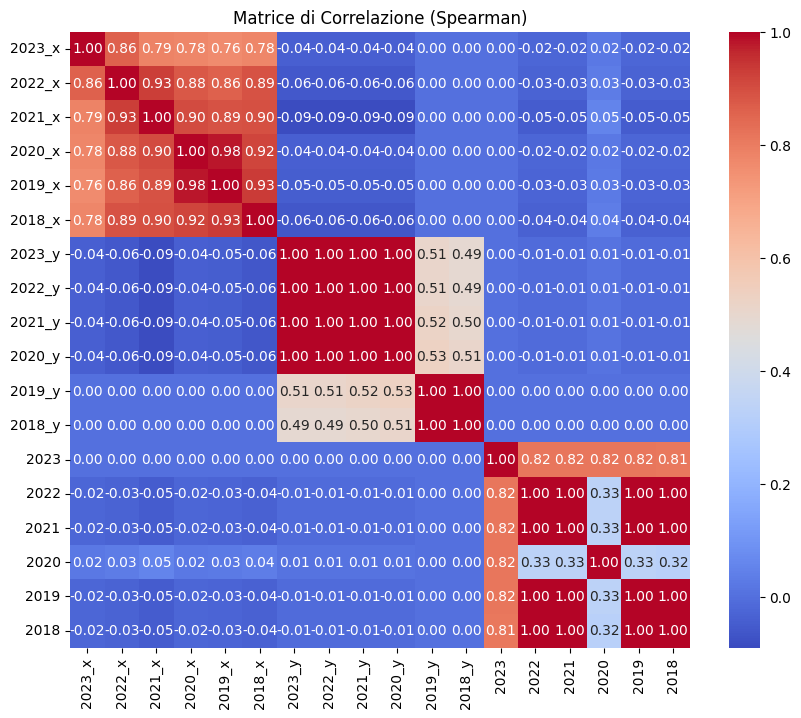

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione (Spearman)')
plt.show()

Displayed above are the correlation results presented in a graphical format, akin to earlier visualizations. Warmer-colored zones indicate a stronger correlation between the paired years, while colder ones suggest a potential absence of correlation. It is crucial to reiterate, as emphasized throughout this notebook, that in the latter scenario, a significant volume of data has been artificially generated using the <code>knn_impute</code> function. This function adeptly replaces NaN values by employing the logic of k-nearest neighbor imputation, contributing to a more comprehensive dataset for analysis.

### Clusters and visualization

Like before in this section, the same approach oc finding and evaluating possible clusters among the data has been employed to identify any patterns in the dataset. Once again before proceeding with the cluster identification, it is necessary to employ the elbow method to determine the optimal number of clusters by which to partition the dataset.

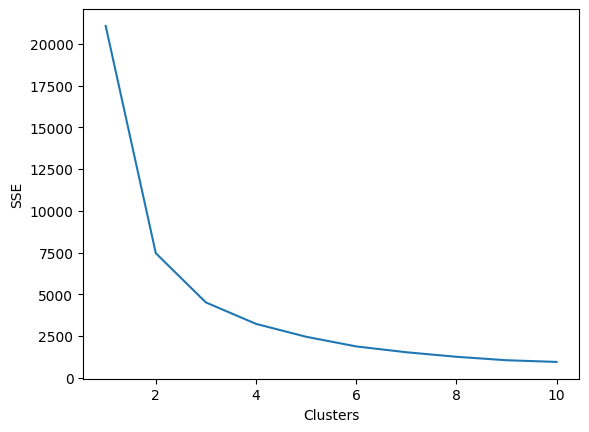

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import cluster

Y = merged_df_final2.iloc[:,1:].values

# Apply elbow method to understand the number of cluster

wcss = []
for i in range(1,11):
    k_means = cluster.KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(Y)
    wcss.append(k_means.inertia_) 

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In this case as before, there is some space for interpretations or trials for the numbers of cluster to select, even if it is quite undeniably clear that the optimal amount of cluster in this situation is 4.

In [318]:
from sklearn.cluster import KMeans
import pandas as pd

data = merged_df_final2.select_dtypes(include=[np.number])
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
labels = kmeans.labels_
merged_df_final2['Cluster'] = labels
labels
cluster_means = merged_df_final2.groupby('Cluster').mean()
cluster_means


,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
Cluster,,,,,,,,,,,,,,,,,,
0,7.445000,6.445000,6.295000,5.945,6.130000,6.045,19.900,17.900,18.400,17.300,13.700,14.300,3.00,2.600,2.400,2.600,2.300,2.600
1,39.666667,38.333333,39.333333,38.000,37.333333,37.000,19.900,17.900,18.400,17.300,13.700,14.300,3.00,2.600,2.400,2.600,2.300,2.600
2,11.604000,11.980000,12.320000,11.772,10.764000,12.292,19.316,17.396,17.856,16.772,13.388,13.892,3.12,2.768,2.512,2.608,2.304,2.648
3,18.800000,18.800000,17.600000,21.000,19.600000,18.800,19.900,17.900,18.400,17.300,13.700,14.300,3.00,2.600,2.400,2.600,2.300,2.600


As it is possible to see in the result above this cell the calculus of the average values of the clusters shows the difference in the avrage values of theclusters that suggest the choice of 4 clusters.

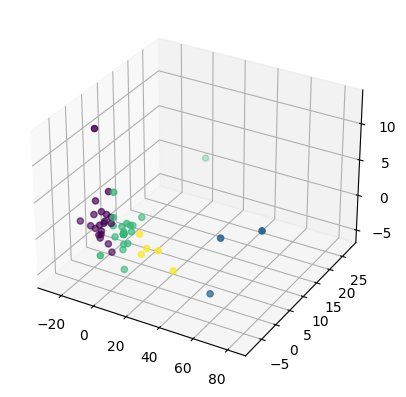

In [319]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Riduci la dimensionalità dei tuoi dati a 3 dimensioni utilizzando PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Crea una nuova figura
fig = plt.figure()

# Aggiungi un grafico 3D alla figura
ax = fig.add_subplot(111, projection='3d')

# Assegna a x, y, e z le tre componenti principali
x = reduced_data[:, 0]
y = reduced_data[:, 1]
z = reduced_data[:, 2]

# Crea un grafico a dispersione 3D utilizzando le etichette dei cluster per colorare i punti
scatter = ax.scatter(x, y, z, c=labels)

# Mostra il grafico
plt.show()


Again we use a 3d visualization to better understand the poatterns and the disposition of clusters and of each point that belongs to them. Same as before this visualization is obtained by the reduction of dimensionality, as performed by techniques like Principal Component Analysis (PCA), that has been explained before.

In [320]:
# Per ciascun cluster
for cluster in merged_df_final2['Cluster'].unique():
    # Seleziona solo le righe per questo cluster
    cluster_data = merged_df_final2[merged_df_final2['Cluster'] == cluster]
    
    # Ottieni i nomi delle agenzie in questo cluster
    agencies = cluster_data['Agency']
    
    # Stampa le agenzie
    print(f'Cluster {cluster}:')
    print(agencies.head())


Cluster 0:
0    Agency for the Cooperation of Energy Regulator...
1    Body of European Regulators for Electronic Com...
6    European Agency for the Management of Operatio...
7    European Agency for the Operational Management...
9               European Aviation Safety Agency (EASA)
Name: Agency, dtype: object
Cluster 2:
2        Community Plant Variety Office (CPVO)
3                  Euratom Supply Agency (ESA)
4     European Agency for Reconstruction (EAR)
8        European Asylum Support Office (EASO)
16    European Fisheries Control Agency (EFCA)
Name: Agency, dtype: object
Cluster 1:
5     European Agency for Safety and Health at Work ...
12    European Centre for the Development of Vocatio...
20    European Foundation for the Improvement of Liv...
Name: Agency, dtype: object
Cluster 3:
11    European Centre for Disease Prevention and Con...
13                     European Chemicals Agency (ECHA)
15                    European Environment Agency (EEA)
34                   Europ

For the same convenience principle that guided us before we decided to show the labels of the different clusters that have been created through the calculation applied in the steps above in order to see the agencies that share similar trends in the disposition of important roles held by women trough the years.